# Week 1 Lab: next generation sequencing and mutation hunting

## Part 2
**Due: Monday 4/8/19**

**Partner: ** (optional. Indicate which partner is turning in the assignment)

Skills covered: TODO


In [ ]:
# Set up code
%pylab inline
import os
import numpy as np

HOMEDIR="/home/mgymrek/workspace/cse185-spring19/1_NGS/data_prep" # TODO change

## 1. Preparing for SNP calling: pileup files

The goal now is to go through our data, and for each position in the reference genome, see how many reads have a mutation at the same position. The tview image looks great, but would take too long to go through the entire human genome. The SAM file is inconvenient for this, because the reads aren’t matched with the reference in a simple way (though they do contain all the information needed to make the alignment in tview). The solution is to make an intermediate file type called an mpileup, because it goes through each position and “piles up” the reads, tabulating the number of bases that match or don’t match the reference.

Like tview, mpileup requires a sorted, indexed bam file. We will focus only on a specific region of the genome to make this go faster. Run `samtools mpileup` to see the usage information. Then run the basic command below. 

```
samtools mpileup -r chr6:128405804-128605805 -f hg19.fa NA12878_child.sorted.bam > NA12878_child.mpileup
```

See what the pileup looks like with `head -n 100`. These files will be more convenient for SNP calling, since they "pileup" all the bases sequenced at each position in the reference genome. Read about pileup format here: http://samtools.sourceforge.net/pileup.shtml.

<blockquote>
**UNIX TIP**: Sometimes files with long lines are hard to read in the terminal screen because the lines get "wrapped". I like to pipe output to `less -S` which allows you to scroll horizontally. Try it out with the command below.
</blockquote>

```
head -n 100 NA12878_child.mpileup | less -S
```

Now look at the usage of `samtools mpileup` to determine how to run the command on multiple BAM files at once (child, father, and mother, in that order so everyone's files are consistent). Output the results to `trio.mpileup`.

To examine the output, we'll learn a new UNIX command, `grep`, which is a useful tool for searching files for specific string patterns (kind of like "ctrl+F" or "find" functions in other tools). Try the command below:

```
cat trio.mpileup | grep 128419307
```

<font color="red" size="3" style="background-color:#f2e3e5">**Question 1 (3 pts)**: How many reads does each smaple (child, mother, father) have covering the position chr6:128419307? What does it look like the genotype of each sample is? (TT, AT, or AA)? Answer the same questions for position chr6:128435303 (coverage and genotype for each sample).</font>

<font color="blue" size="3" style="background-color:#e2e6f1">**Answer 1**</font>

## 2. Plotting the coverage distribution

The mpileup format makes it straightforward to plot the coverage distribution for each sample. We can simply pull out the columns of the file for each sample correponding to coverage. 

<font color="red" size="3" style="background-color:#f2e3e5">**Question 2 (4 pts)** Complete the code below to plot the distribution of coverage and compute the mean of the distribution for each sample. </font>

<font color="blue" size="3" style="background-color:#e2e6f1">**Answer 2**</font>

Populating the interactive namespace from numpy and matplotlib
Mean child coverage: 50.7579824201758


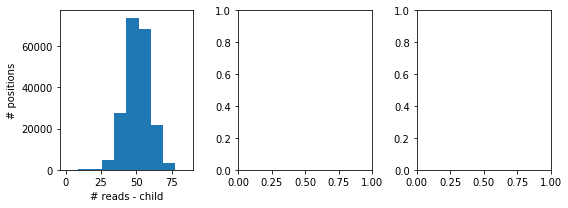

In [19]:
%pylab inline
import os
import pandas as pd
import numpy as np

covdata = pd.read_csv(os.path.join(HOMEDIR, "trio.mpileup"), sep="\t",
                     names = ["cov.child", "cov.father", "cov.mother"],
                     usecols = [3, 6, 9])

# Set up the plot
fig = plt.figure()
fig.set_size_inches((8, 3))

# Plot child coverage distribution
ax = fig.add_subplot(131)
ax.hist(covdata["cov.child"])
ax.set_xlabel("# reads - child")
ax.set_ylabel("# positions")
print("Mean child coverage: %s"%np.mean(covdata["cov.child"]))

# Plot father coverage distribution
ax = fig.add_subplot(132)
# TODO fill in this section

# Plot mother coverage distribution
ax = fig.add_subplot(133)
# TODO fill in this section

# Clean up the plot spacing
fig.tight_layout();

## 3. Running a SNP caller (Varscan)

Now we will run a SNP caller to identify variants in our three samples. We could parse the mpileup file ourselves to do this, but there are already dozens of existing SNP callers out there so for now we'll choose not to reinvent the wheel.

Until now, all the programs you have been using (BWA, fastqc, samtools...) were pre-installed for you in our public folder. Here you’ll get to try your hand at installing one type of program file.

Use the command below (`curl` - it's a linux/unix command to access websites) to download VarScan into your `week1` folder. Notice that we are redirecting the contents of the download into a .jar file.

```
curl -L https://sourceforge.net/projects/varscan/files/VarScan.v2.3.9.jar/download > VarScan.jar
```

Try to bring up the man page with:
```
java -jar VarScan.jar
```

This install method won’t be the same for all bioinformatics programs, and it might not even be the same for other java programs, as installing open source software often has dependencies (prerequisite software) and can be sensitive to where its installed and how it is executed. We'll try to touch on this throughout the course.


On the VarScan man page, you should see several commands. We are interested in the mpileup2snp command. Go ahead and enter it with `-h` to bring up the manual.

```
java -jar VarScan.jar mpileup2snp -h
```

There are lots of ways we could filter our data. VarScan lets the user define their own cutoffs for including data in calling variants, other programs rely on complex statistical procedures to evaluate the likelihood of real mutations.

The first option we are interested in setting today is the -`-min-var-frequency` option. This sets the minimum % of non-reference bases at a position required to call it a variant in the sample. Set this too low, and we'll pick up mostly sequencing errors. Set this too high, and we'll miss real variants. We're also interested in `--min-freq-for-hom`, the minimum % of non-reference bases to call a variant homozygous.

Choose reasonable thresholds that will allow us to pick up both heterozygous and homozygous variants. 

<font color="red" size="3" style="background-color:#f2e3e5">**Question 3 (4 pts)**: Choose reasonable thresholds to modify and run the command below to perform SNP calling.</font>

<font color="blue" size="3" style="background-color:#e2e6f1">**Answer 3**</font>

```
java -jar VarScan.jar mpileup2snp \
  trio.mpileup \
  --min-var-frequency N \
  --min-freq-for-hom N \
  --variants \
  --p-value 0.01 \
  --output-vcf 1 > trio.vcf
```

## 4. Intro to VCF files

VarScan outputs variants in VCF (variant call format), a standard genomics format. To read about all the gory details of VCF files, see the specs: https://samtools.github.io/hts-specs/VCFv4.2.pdf

First take a peak and scroll through the file:

```
cat trio.vcf | less -S
```

Key things to notice:

* The header lines (starting with "#") give general information about the file such as the tool use to generate it and a description of all the different data fields in the file.
* Below the header, there is one line per variant. For each variant, you can find the chromosome, position, reference allele, alternate allele, and additional info. Following these fields are the variant call and statistics for each sample
* "INFO" fields describe per-variant statistics. "FORMAT" fields describe per-sample statistics at each variant.

See lecture slides for more VCF info.

<font color="red" size="3" style="background-color:#f2e3e5">**Question 4 (4 pts)**: Look at the position chr6:128593590 (it might be helpful to use grep for this). What is the genotype for each of the three samples? What is the p-value for each?</font>

<font color="blue" size="3" style="background-color:#e2e6f1">**Answer 4**</font>

## 5. Inspecting putative variants

It is always a good idea to look at the raw data used to make genotype calls. Use `samtools tview` to navigate to position chr6:128593590 in the BAM files for each of your samples. Does the raw data support the genotype called by VarScan? Look at the alignments for several other positions with SNP calls.

## 6. Mutation identification and annotation

We'd now like to identify potential *de novo* mutations that occurred in the child genome but that were not passed down by either parent. 

<font color="red" size="3" style="background-color:#f2e3e5">**Question 5 (15 pts)** In the space below, write a small program that identifies candidate mutations in the child genome.

You may do this using whatever means you want, but example template code to get you started using the PyVCF library is provided. This can also be done using bash commands. Your code must run from within the notebook and output a list of candidate mutation positions.

Note you could also do this manually, since our VCF file is pretty small. But we will give only 1 point for solutions with no code provided.

<br><br>
Your code should output one line per candidate mutation in the format:<br>
chrom,position,child genotype;father genotype;mother genotype
</font>

<font color="blue" size="3" style="background-color:#e2e6f1">**Answer 5**</font>

In [42]:
#### TODO replace this with your answer ####
#### Template code is provided to get you started with the PyVCF library ####
#### But you DO NOT have to use it! ####
#### For more info see https://github.com/jamescasbon/PyVCF

# This code simply prints out each position in the VCF file and the genotypes
# of each sample. Modify to print out only positions with putative mutations
# in the child.

import vcf

reader = vcf.Reader(open(os.path.join(HOMEDIR, "trio.vcf"), "r"))

for record in reader:
    chrom  = record.CHROM
    pos = record.POS
    child_gt = record.genotype("Sample1").gt_bases
    father_gt = record.genotype("Sample2").gt_bases
    mother_gt = record.genotype("Sample3").gt_bases

    print("%s:%s:%s;%s;%s"%(chrom, pos, child_gt, father_gt, mother_gt))

chr6:128414945:T/T;T/T;T/T
chr6:128419307:T/A;T/A;T/A
chr6:128421762:T/T;T/T;T/T
chr6:128435303:C/T;C/T;C/T
chr6:128442104:G/G;G/G;G/T
chr6:128446509:T/T;T/T;T/T
chr6:128450019:T/G;T/G;T/T
chr6:128465668:C/T;C/C;C/T
chr6:128469937:T/A;T/A;T/A
chr6:128471913:A/C;A/C;A/C
chr6:128484504:A/G;A/G;A/A
chr6:128486139:A/C;A/C;A/C
chr6:128488195:T/C;T/C;T/C
chr6:128493991:G/T;G/T;G/T
chr6:128494093:C/G;C/G;C/G
chr6:128496528:T/T;T/T;T/C
chr6:128496557:T/T;T/T;T/T
chr6:128503550:T/C;T/C;T/T
chr6:128505804:A/C;A/A;A/A
chr6:128514053:G/A;G/A;G/A
chr6:128515718:T/C;T/C;T/T
chr6:128517169:T/T;T/T;T/C
chr6:128532763:G/C;G/C;G/C
chr6:128559329:C/T;C/T;C/T
chr6:128564669:G/T;G/T;G/T
chr6:128568999:C/T;C/T;C/C
chr6:128572877:C/A;C/A;C/A
chr6:128583972:G/A;G/G;G/A
chr6:128583983:T/G;T/T;T/G
chr6:128585618:A/C;A/C;A/C
chr6:128591818:T/G;T/G;G/G
chr6:128593590:T/T;T/T;T/G
chr6:128599580:C/A;C/A;C/A
chr6:128599902:A/A;A/A;A/A
chr6:128602090:A/C;A/C;A/C
chr6:128602577:T/C;T/C;T/C
chr6:128602796:C/T;C/T;C/T
c

Now let's figure out if the mutations identified are likely to have an impact on any particular genes. We'll use the UCSC Genome Browser (https://genome.ucsc.edu/) to help with this. Go to the genome browser home page. Then on the top menu bar, hover over "Genomes" and choose the hg19 reference genome.

<font color="red" size="3" style="background-color:#f2e3e5">**Question 6 (5 pts)**: In the search bar, navigate to the position of each mutation. e.g. "chr6:XXXX" in the search bar. Does your mutation fall in any genes? If yes, determine whether it is predicted to change the amino acid structure (i.e. is this a synonymous variant? missense? nonsense?) of the protein and describe the change below.</font>

<font color="blue" size="3" style="background-color:#e2e6f1">**Answer 6**</font>

# Additional challenge questions

TODO: anomalies in sequencing coverage

TODO: anomalies in insert size distributions

TODO: SNP calling error sources